In [430]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(11.7*1.3, 8.27*1.3)})
sns.set_theme(style="whitegrid", palette="deep") #pastel
sns.set_context("paper", font_scale=1.5)

import numpy as np
import pandas as pd
#pd.options.plotting.backend = "sns"#"plotly"

from fancyimpute import KNN

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sys import getsizeof
import missingno as msn

In [431]:
df = pd.read_csv('./data/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Анализ признаков

### Посмотрим на целевой признак

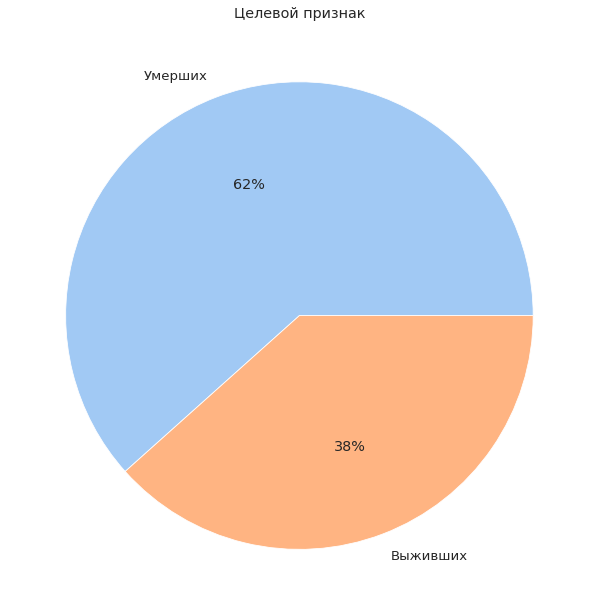

In [432]:
colors = sns.color_palette('pastel')[0:5]
df_temp = df['Survived'].value_counts()
plt.pie(df_temp, labels =('Умерших', 'Выживших') , colors = colors, autopct='%.0f%%')
plt.title('Целевой признак')
plt.show()

#### Два значения в целевом признаке. Следовательно решается задача бинарной классификации.
#### Классы не сбалансированы - метрику accuracy нельзя использовать

__________
### Посмотрим на пропущеные значения

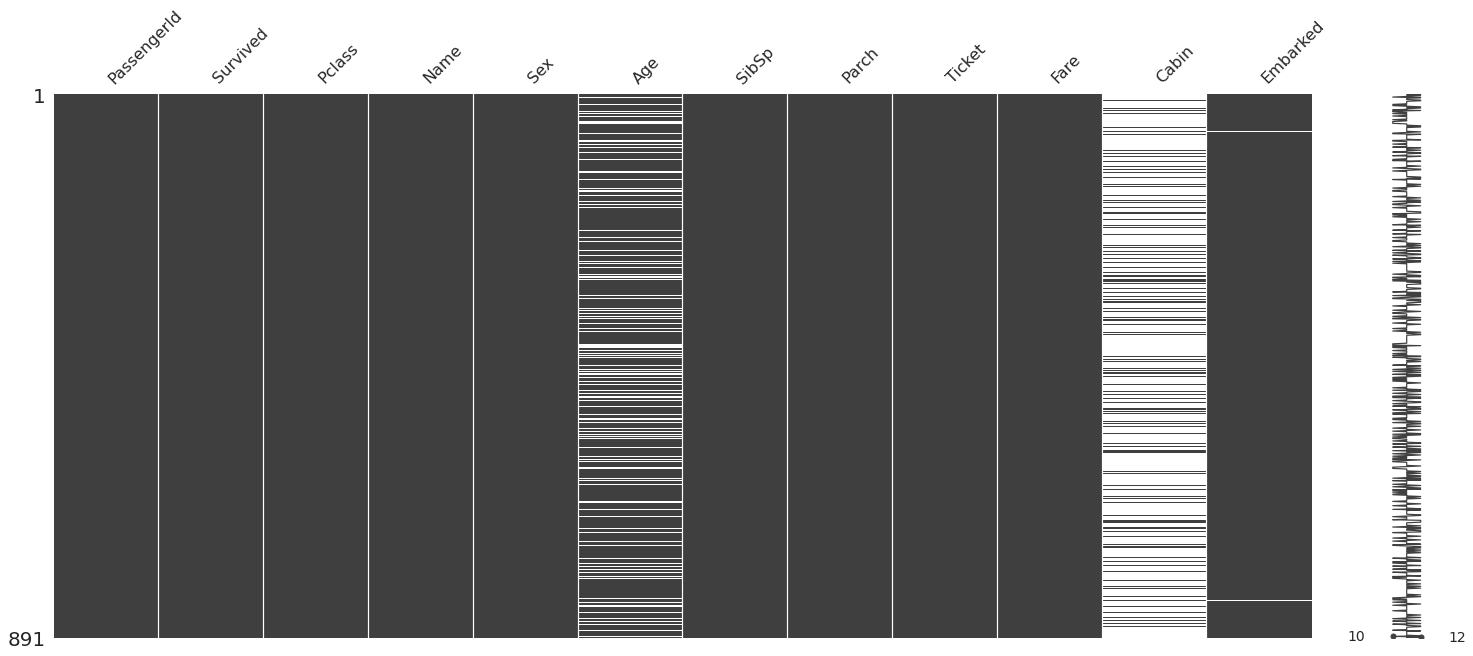

In [433]:
msn.matrix(df);

#### Признак Cabin слишком пустой
#### В признаке Embarked пара пустых значений. Эти строки можно удалить, либо заполнить используя метод ближайших соседей

__________
### Посмотрим на уникальные значения в желаемых признаках

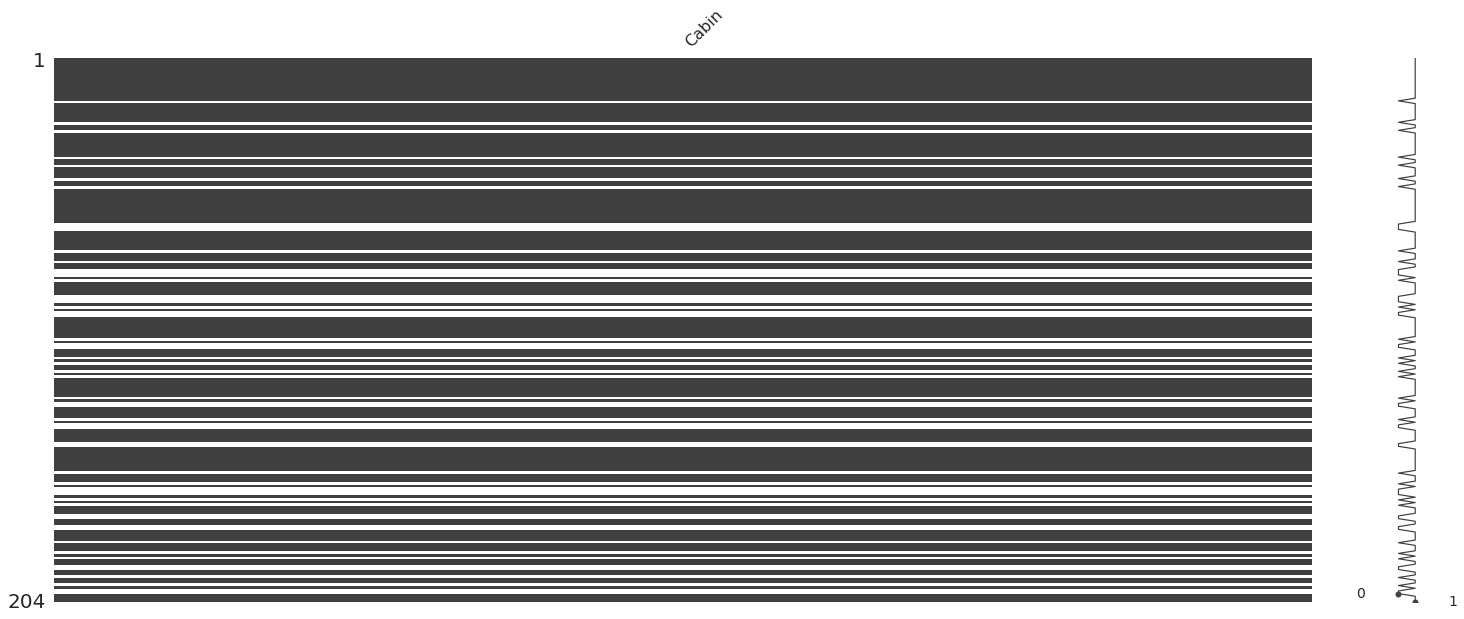

In [434]:
df_duplicateds = pd.DataFrame([(df[col].dropna().duplicated()).astype(int).replace(1,np.nan) for col in ['Cabin']]).T
msn.matrix(df_duplicateds);

#### В признаке Cabin много дубликатных значений (nan игнорируются). Объяснить можно тем, что на титанике были каюты для нескольких человек.

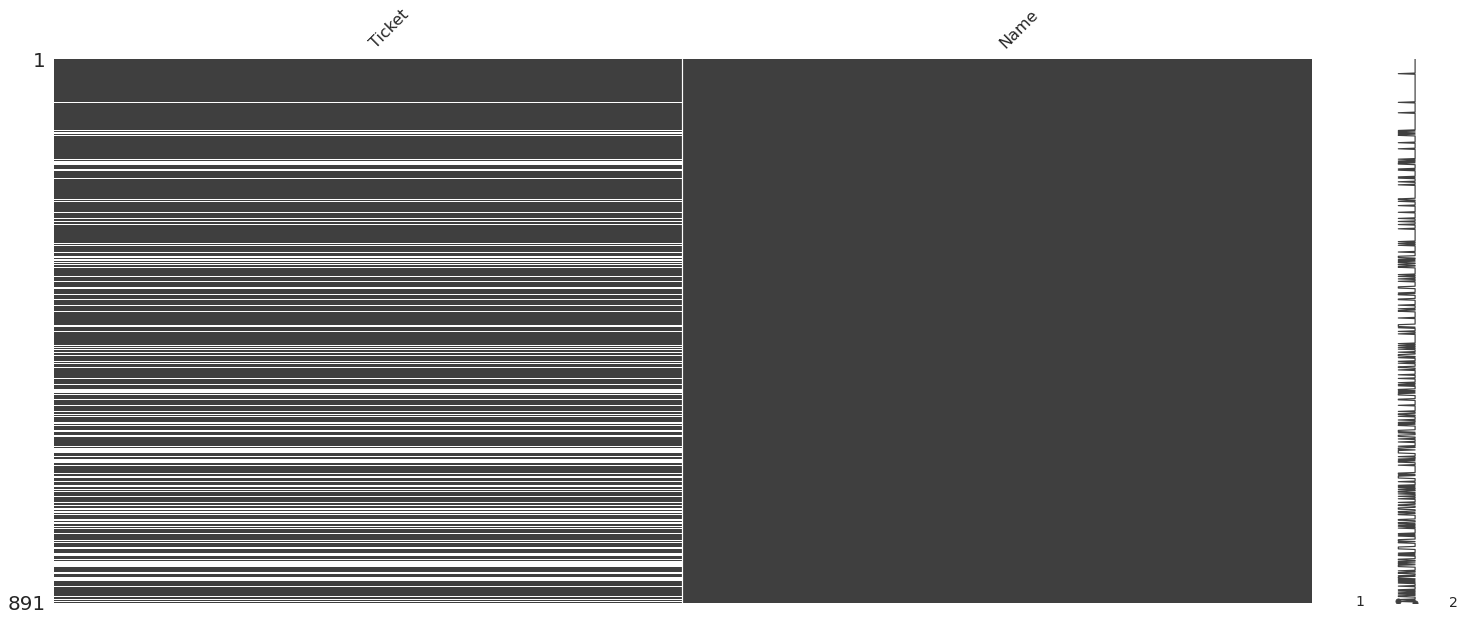

In [435]:
df_duplicateds = pd.DataFrame([(df[col].dropna().duplicated()).astype(int).replace(1,np.nan) for col in ['Ticket', 'Name']]).T
msn.matrix(df_duplicateds);

#### В признаке Ticket много дубликатных значений

__________
### Процент выживыших для каждого класса

In [436]:
def percentage_of_survivors(x):
    return f"{round(100*sum(x == 1)/ len(x), 2)}%"

df.groupby(['Pclass']).agg({'Survived':percentage_of_survivors})

,Survived
Pclass,
1,62.96%
2,47.28%
3,24.24%


#### Видно, чем выше класс, тем большая его часть выжила

________
### Выжил или нет в зависимости от пола

,Survived
Sex,
female,74.2%
male,18.89%


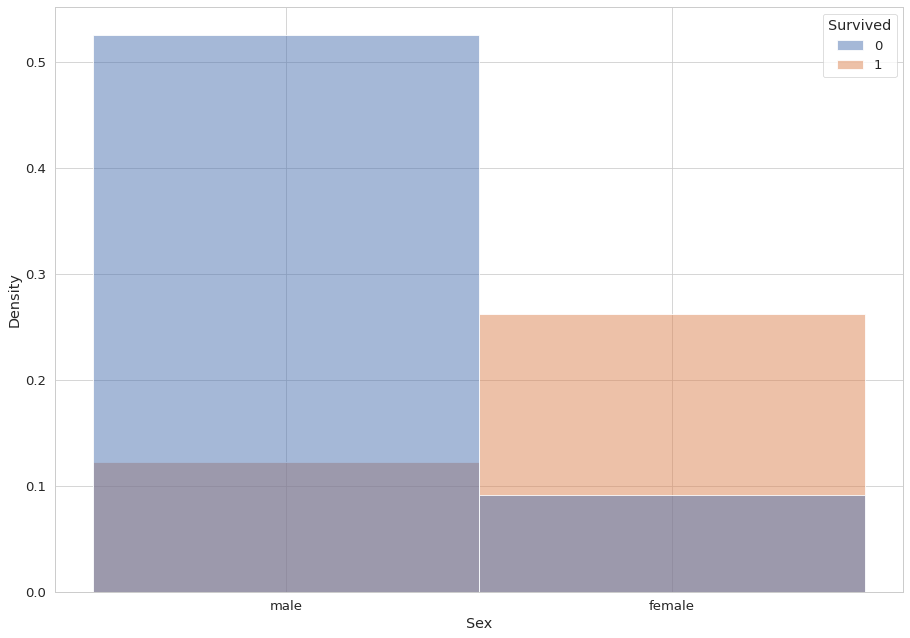

In [437]:
sns.histplot(df, x='Sex',hue='Survived', stat="density" )
df.groupby(['Sex']).agg({'Survived':percentage_of_survivors})

#### У женщин доля выживших значительно больше, чем у мужчин.
#### Это логично, так как капитан коробля дал указание сажать в спасательные шлюпки сначала женщин и детей.

________
### Процент выживших в зависимости от количества родственников

In [438]:
# признак показывает, сколько вообще родственников у пассажира 
df['family_size'] = df['SibSp'] + df['Parch']

df.groupby(['family_size']).agg({'Survived': percentage_of_survivors})

,Survived
family_size,
0,30.35%
1,55.28%
2,57.84%
3,72.41%
4,20.0%
5,13.64%
6,33.33%
7,0.0%
10,0.0%


#### Кажется, что для спасения идеально иметь немного родственников. Прежде, чем делать вывод, проверим количество родственников в зависимости от класса

_______
### Количество родственников и их процент выживаемости для каждого класса

In [439]:
df.groupby(['Pclass', 'family_size']).agg({'Survived':[percentage_of_survivors, 'count'],})

Survived      
                   percentage_of_survivors count
Pclass family_size                              
1      0                            53.21%   109
       1                            72.86%    70
       2                             75.0%    24
       3                            71.43%     7
       4                            100.0%     2
       5                             50.0%     4
2      0                            34.62%   104
       1                            52.94%    34
       2                            67.74%    31
       3                            76.92%    13
       4                            100.0%     1
       5                            100.0%     1
3      0                             21.3%   324
       1                            35.09%    57
       2                            42.55%    47
       3                            66.67%     9
       4                              0.0%    12
       5                              0.0%    17
       6                            33.33%    12
       7                              0.0%     6
       10                             0.0%     7

#### Из таблицы видно, в первом и во втором классах количество родственников очень редко больше 3. И кажется, что предыдущий результат показал именно это - если мало близких, значит ты едешь в высоком классе и именно поэтому шансы спастись увеличиваются. Однако, в низком классе заметно, что большие семьи плохо выживают. Но это объясняется тем, что в тренировочных данных для 5 человек показывается, что у них 5 родственников, а значит это одна семья. Из одного - двух примеров статистику не построишь, поэтому нельзя твердо утвержать, что количество людей в семье влияет на выживаемость.

___________
### Зависимость возраста и цены от выживаемости в классах

Age          Fare       
                  mean median   mean median
Pclass Survived                            
1      0         43.70  45.25  64.68  44.75
       1         35.37  35.00  95.61  77.96
2      0         33.54  30.50  19.41  13.00
       1         25.90  28.00  22.06  21.00
3      0         26.56  25.00  13.67   8.05
       1         20.65  22.00  13.69   8.52

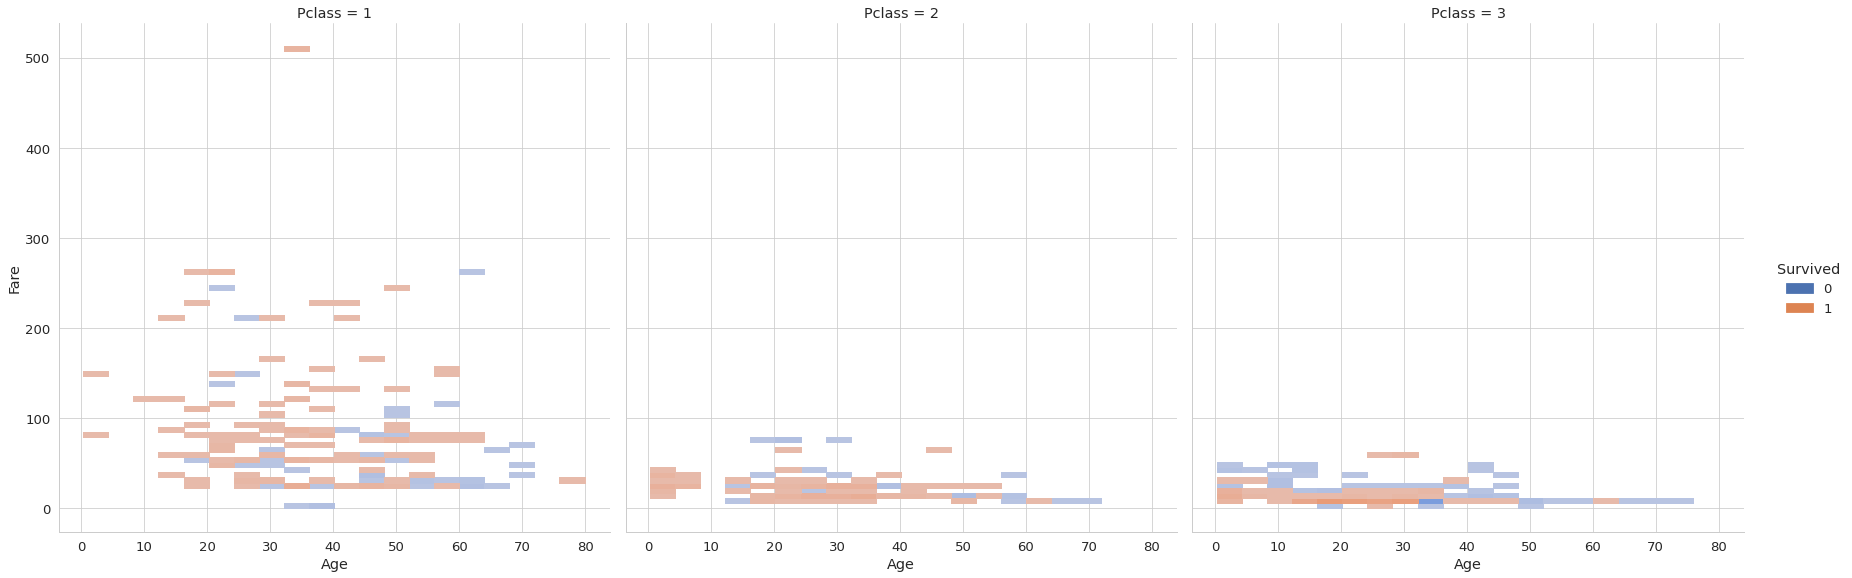

In [440]:
sns.displot(df, x="Age", y="Fare", col='Pclass', hue='Survived' , height=8.27, aspect=1);
df.groupby(['Pclass', 'Survived']).agg({'Age':['mean', 'median'], 'Fare':['mean', 'median']}).round(2)

#### Можно сделать вывод, что лучше выживают более богатые, а в группах по богатству более молодые

### В признаке Cabin обнаружено, что есть пассажиры с несколькими каютами

In [441]:
df['count_cabin'] = df['Cabin'].astype(str).map(lambda x: len(x.split(' ')))

df.groupby(['Survived', 'count_cabin']).agg({'count_cabin':'count' })

count_cabin
Survived count_cabin             
0        1                    539
         2                      7
         3                      3
1        1                    328
         2                      9
         3                      3
         4                      2

# Обработка признаков

In [442]:
def claster_fillna(df, name_feature):
    #scaler = preprocessing.StandardScaler()
    index_feature = df.columns.tolist().index(name_feature)    
    #standardized_feature = scaler.fit_transform(df)

    impute_feature = KNN(k=2, verbose=0).fit_transform(df)[:, index_feature]
    return impute_feature

# категориальные признаки
cols_cat =['Pclass', 'Sex', 'SibSp', 'family_size', 'Embarked', 'Ticket_duplicate', 'Parch',
           'Ticket', 'Cabin', 'Cabin_count_psng', 'Words_in_name', 'last_name',  'first_Name']
# текстовый признак
cols_txt = ['Name']

# 22.86 Растояние от палубы, на которой находились спасательные шлюпки, до нижнего жилого этажа
# 7 - количество жилых этажей
l = 22.86/7
# словарь для перевода кабины в шкалу расстояния от верхней палубы 
distance_to_deck = {'A':l , 'B':2*l , 'C':3*l , 'D':4*l , 'F':5*l , 'E':6*l , 'G':7*l }

def clear_df(df):
    # создание признака, показывающий расстояние до верхней палубы
    df['Cabin_distance'] = df['Cabin'].apply(lambda x: distance_to_deck.get(str(x)[0], np.nan))
    # признак - состоит ли билет только из цифр
    df['Ticket_onlynum'] = df['Ticket'].apply(lambda x: int(x.isdigit()))
    # дубликатный ли билет (0 - нет, 1-да)
    df['Ticket_duplicate'] = df['Ticket'].duplicated().astype(int)
    # количество пассажиров в кабине
    df['Cabin_count_psng'] = df['Cabin'].astype(str).map(lambda x: len(x.split(' ')))
    # Кодирование категориальных признаков
    #df['Embarked'] = df['Embarked'].apply(lambda x: {'S':0, 'C':1, 'Q':2}.get(x, -1))
    df['Sex'] = df['Sex'].apply(lambda x: {'male':0, 'female':1}.get(x, -1))
    # добавляем признак "логарифм цены"
    df['Fare_log'] = np.log(df['Fare'] + 1)
    # признак показывает, сколько вообще родственников у пассажира 
    df['family_size'] = df['SibSp'] + df['Parch']
    # асстояние от палубы с шлюпками до палубы пассажира
    df['Cabin_distance'] = claster_fillna(df.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']), 'Cabin_distance')
    
    df[['Fare', 'Fare_log','Parch']] = df[['Fare', 'Fare_log', 'Parch']].fillna(-1)
    df[['Fare', 'Fare_log','Parch']] = df[['Fare', 'Fare_log', 'Parch']].astype(float)
    
    # Названия с очень низким количеством ячеек будут объединены до уровня "редкие"
    rare_titles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
    df['Name'].replace(rare_titles, "Rare title", inplace=True)
    # "Mlle","Ms", "Mme" переводим в шкалу "Miss", "Mrs"
    df['Name'].replace(["Mlle","Ms", "Mme"], ["Miss", "Miss", "Mrs"], inplace=True)
    
    df['Words_in_name'] = df['Name'].str.findall('[A-Za-z]+').apply(len)
    
    # берем только имя
    df['first_Name'] = df['Name'].apply(lambda x: x.split(',')[0].strip())
    df['first_Name'] = df['first_Name'].str.lower()
    
    df['last_name'] = df['Name'].apply(lambda x: x.split(' ')[-1].strip())
    bad_chars = ('"', '(', ')', '-',)
    for bad_char in bad_chars:
        df['last_name'] = df['last_name'].str.replace( bad_char, '')
        
    df['last_name'] = df['last_name'].str.lower()
    
    df[cols_cat] = df[cols_cat].fillna('')
    df[cols_txt] = df[cols_txt].fillna('')
    df[cols_cat] = df[cols_cat].astype(str)
    df[cols_txt] = df[cols_txt].astype(str)
    
    # Удаление признаков
    df = df.drop(columns=['PassengerId'])
    
    df[['Fare', 'Fare_log', 'Age']] = (df[['Fare', 'Fare_log', 'Age']] - df[['Fare', 'Fare_log', 'Age']].mean())/df[['Fare', 'Fare_log', 'Age']].std()
    
    return df

In [443]:
# Загрузка данных
df = pd.read_csv('./data/titanic/train.csv')
df_test = pd.read_csv('./data/titanic/test.csv')


df_target = df.pop('Survived')
df = clear_df(df)
df_test = clear_df(df_test)

## Индексы категориальных и текстовых фичей

In [444]:
cat_ind = [i for i, col in enumerate(df.columns) if col in cols_cat]
text_ind = [i for i, col in enumerate(df.columns) if col in cols_txt]

## Разделение на тесотвую и валидационную подвыборки

In [349]:
X_train, X_test, y_train, y_test = train_test_split(df.values,
                                                    df_target.values,
                                                    train_size=0.6,
                                                    random_state=42)

# Обучение модели

In [354]:
model = CatBoostClassifier(iterations=15000,
                           depth=5,
                           learning_rate=0.0001,
                           l2_leaf_reg=0.01,
                           random_seed=421,
                           eval_metric='Accuracy',
                           use_best_model=True,
                           bagging_temperature=0.,
                           #bootstrap_type='MVS',
                           verbose=False)

model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_ind,
    text_features=text_ind,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Точность на валидационной подвыборке

In [428]:
accuracy_score( y_test, model.predict(X_test) )

0.8291316526610645

# Обучение на полных данных

In [356]:
full_model = CatBoostClassifier(**model.get_params())

full_model.fit(
    df.values,
    df_target.values,
    eval_set=(X_test, y_test),
    cat_features=cat_ind,
    text_features=text_ind,
)

____________
## Анализ модели

### Важность признака для модели

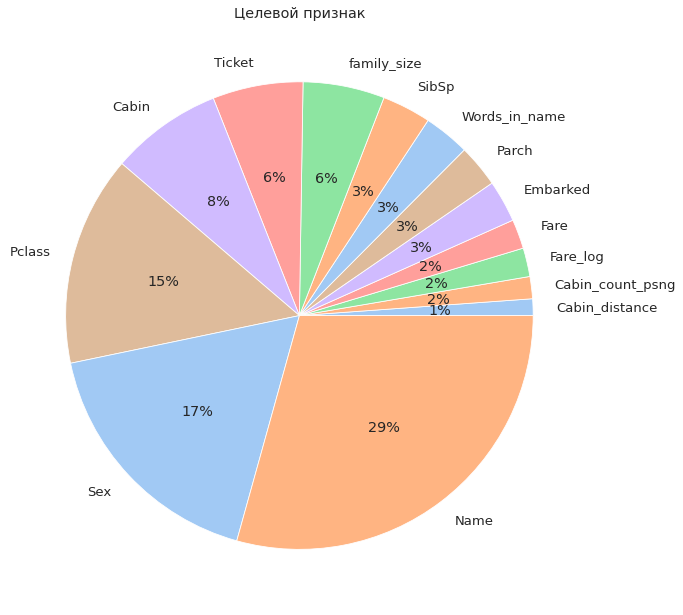

In [427]:
# извлекаем из модели важность признаков
df_temp = pd.DataFrame(sorted(list(zip(full_model.feature_importances_, df.columns)), key=lambda x:x[0]))
df_temp.columns = ['importances', 'features']
# возьмем признаки, которые делают вклад больше 1
df_temp = df_temp[df_temp['importances'] > 1]
# строим график
colors = sns.color_palette('pastel')[0:6]
plt.pie(df_temp['importances'], labels= df_temp['features'], colors = colors, autopct='%.0f%%')
plt.title('Целевой признак')
plt.show()

### Cкорость обработки 891 запроса примерно 15 миллисекунд

In [421]:
%%time
_ = full_model.predict(df.values);

CPU times: user 40.7 ms, sys: 15.7 ms, total: 56.4 ms
Wall time: 17.8 ms


___________
##  Сохранение предсказаний для kaggle

In [425]:
predicts = full_model.predict(df_test.values)
df_sub = pd.read_csv('./data/titanic/gender_submission.csv')
df_sub['Survived'] = predicts
df_sub.to_csv('gender_submission.csv', index=False)

### Точность на kaggle: 0.80622

_______
## Сохраненеи модели

In [361]:
def _model_save():
    full_model.save_model('./model/model')

    with open('./model/params.txt', 'w') as f:
        f.write(str(full_model.get_params()))

In [362]:
_model_save()